<img src="img/14858512893477_so-logo.png" width="600px">    

# Catégorisez automatiquement des questions


<a id="top"></a>
# Sommaire

* [1. Process modélisation](#1)
* [2. Mise en forme](#1)
    * [2.1 Import](#2.1)
    * [2.2 Bag of words](#2.2)
    * [2.3 TF-IDF](#2.3) 
    * [2.4 Word2vec](#2.4)
    * [2.5 Visualisation](#2.5) 
* [3. Approche non supervisée](#3)
    * [3.1 LDA](#3.1) 
    * [3.2 NMF](#3.2)
* [4. Approche supervisée](#4)
    * [4.1 Doc2vec](#4.1) 
    * [4.2 SGD, Logistic regression, LinearSVC](#4.2)
* [5. Installation du modèle sur API](#5)
  *   [5.1 Dump](#5.1)
    * [5.2 Mise en forme process](#5.2) 

In [3]:
%matplotlib inline

# Generic librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell

# ML librairies
from gensim import corpora, models, similarities
from sklearn import metrics, decomposition, multiclass


# API, model management
from flask import Flask
import joblib # to save and load the model

# pd.set_option('display.max_column', 100)

# Activate multi output
InteractiveShell.ast_node_interactivity = "all"

# # For jupyter NB users 
# # set size of window
# display(HTML(data="""
# <style>
#     div#notebook-container    { width: 95%; }
#     div#menubar-container     { width: 65%; }
#     div#maintoolbar-container { width: 99%; }
# </style>
# """))

<a id="1"></a>
# 1. Process modélisation

---


Nous sommes face à un problème de classification multi label.
Nous cherchons pour chaque question à prédire un ou plusieurs tags.

<img src="img/multi label class.png" width="500px">   

Nous allons tout d'abord mettre en forme nos données pour les vectoriser.  
Cela afin qu'elles puissent être en paramètre d'entrée des algorithmes.

Puis nous tenterons une approche supervisée avant d'enchainer par une approche supervisée.  
Cette dernière devrait être plus performante car elle utilisera les tags existants.

<img src="img/process.png" width="800px">   

Enfin le modèle sélectionné sera utilisé via une API, pour cela une mise en forme pour la mise en production sera nécessaire.


<a id="2"></a>
# 2 Mise en forme
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Sommaire</a>

---

<a id="2.1"></a>
## 2.1 Import

Importons notre dataset et placons le dans un pandas dataframe.  
Nous utiliserons les dates comme index.

In [4]:
file = "data/data_clean.csv"
df_raw = pd.read_csv(file, index_col='CreationDate', parse_dates=True)

In [5]:
df_raw.head()
df_raw.shape
df_raw.info()

,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount,Body_tok,Title_tok,Tags_tok,Text_tok,Text
CreationDate,,,,,,,,,,,,,
2010-09-27 06:56:36,152,66955,i lately had the problem of creating add and e...,good or bad practice for dialogs in wpf with m...,<c#><.net><wpf><mvvm><modal-dialog>,3,12,115,"['lately', 'problem', 'creating', 'add', 'edit...","['good', 'bad', 'practice', 'dialog', 'wpf', '...","['c#', '.net', 'wpf', 'mvvm', 'modal', 'dialog']","['good', 'bad', 'practice', 'dialog', 'wpf', '...",good or bad practice for dialogs in wpf with m...
2008-08-11 08:55:13,147,253229,"in c, are the shift operators (<<,>>) arithmet...","are the shift operators (<<, >>) arithmetic or...",<c><binary><bit-manipulation><bit-shift>,11,1,60,"['c', 'shift', 'operator', 'arithmetic', 'logi...","['shift', 'operator', 'arithmetic', 'logical',...","['c', 'binary', 'bit', 'manipulation', 'bit', ...","['shift', 'operator', 'arithmetic', 'logical',...","are the shift operators (<<, >>) arithmetic or..."
2008-08-11 10:27:22,815,576716,"whenever i design a database, i always wonder ...","database, table and column naming conventions?",<database><database-design><language-agnostic>...,23,4,359,"['whenever', 'design', 'database', 'always', '...","['database', 'table', 'column', 'naming', 'con...","['database', 'database', 'design', 'language',...","['database', 'table', 'column', 'naming', 'con...","database, table and column naming conventions?..."
2008-08-11 11:57:17,110,238131,is this even a valid question? i have a .net w...,how do i enable msdtc on sql server?,<sql-server><msdtc>,6,1,30,"['even', 'valid', 'question', '.net', 'window'...","['enable', 'sql', 'server']","['sql', 'server']","['enable', 'sql', 'server', 'even', 'valid', '...",how do i enable msdtc on sql server? is this e...
2008-08-10 18:41:02,539,197771,"what does the expression ""turing complete"" mea...",what is turing complete?,<theory><turing-machines><turing-complete>,15,1,178,"['expression', 'complete', 'mean', 'give', 'si...",['complete'],"['theory', 'machine', 'complete']","['complete', 'expression', 'complete', 'mean',...",what is turing complete? what does the express...


(28077, 13)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28077 entries, 2010-09-27 06:56:36 to 2018-04-26 23:29:11
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Score          28077 non-null  int64 
 1   ViewCount      28077 non-null  int64 
 2   Body           28077 non-null  object
 3   Title          28077 non-null  object
 4   Tags           28077 non-null  object
 5   AnswerCount    28077 non-null  int64 
 6   CommentCount   28077 non-null  int64 
 7   FavoriteCount  28077 non-null  int64 
 8   Body_tok       28077 non-null  object
 9   Title_tok      28077 non-null  object
 10  Tags_tok       28077 non-null  object
 11  Text_tok       28077 non-null  object
 12  Text           28077 non-null  object
dtypes: int64(5), object(8)
memory usage: 3.0+ MB


In [6]:
# we only keep the texts and the tags
df = df_raw[["Text_tok", "Tags_tok"]].copy()

In [7]:
import ast

# by default list are put in strings by pands, let's convert it to lists
# ast.literal_eval il more secure than eval
df["Text_tok"] = df["Text_tok"].apply(lambda x: ast.literal_eval(x))
df["Tags_tok"] = df["Tags_tok"].apply(lambda x: ast.literal_eval(x))

In [8]:
# we put the text into string form, usefull for vectorizers
df['Text'] = df['Text_tok'].str.join(' ')
df['Tags'] = df['Tags_tok'].str.join(' ')

<a id="2.2"></a>
## 2.2 Bag of words

Nous allons maintenant extraire l'information du texte pour pouvoir le traiter par des modèles de machine learning.

Une représentation bag-of-words classique sera celle dans laquelle on représente chaque document par un vecteur de la taille du vocabulaire  |V|.  
On utilisera la matrice composée de l’ensemble de ces N documents qui forment le corpus comme entrée de nos algorithmes.

In [9]:
# we create a dictionnary of the uniques words of corpus
# each word will have an unique id
dictionary = corpora.Dictionary(df.Text_tok)
print(dictionary)

Dictionary(5286 unique tokens: ['.net', 'achieved', 'add', 'anything', 'anyways']...)


In [58]:
# bag of word (sparse matrix)
# return a list of tuple
# first entry in each tuple corresponds to the ID of the token in the dictionary
# the second corresponds to the count of this token.
bow_corpus = [dictionary.doc2bow(text) for text in df.Text_tok]

In [59]:
# sample
bow_corpus[1]

[(62, 2), (115, 2), (116, 2), (117, 2), (118, 2)]

<a id="2.3"></a>
## 2.3 TF-IDF

Le modèle tf-idf transforme les vecteurs de la représentation bag of word (BOW) en vecteurs dont les fréquences ont pour poids la rareté relative de chaque mot du corpus.

>La métrique tf-idf (Term-Frequency - Inverse Document Frequency) utilise comme indicateur de similarité l'inverse document frequency.  
>Celui ci est est l'inverse de la proportion de document qui contient le terme, à l'échelle logarithmique.  
>Il est appelé logiquement « inverse document frequency » (idf). 

In [12]:
# train the model
model_tfidf = models.TfidfModel(bow_corpus)

# transformation of the corpus
tfidf_corpus = model_tfidf[bow_corpus]

<a id="2.4"></a>
## 2.4 word2vec

Nous allons étudier un modèle de vectorisation des données : Word2vec
Dans l'architecture word2vec, les 2 algorithmes utilisés sont “continuous bag of words” (cbow) et “skip-gram” (sg).

Nous allons entrainer un modèle puis tester les similarités entre les mots.

In [13]:
model_w2v = models.Word2Vec(sentences=df.Text_tok,
window=5,
min_count=5)

In [14]:
model_w2v.wv.similarity("numpy", "matplotlib")
model_w2v.wv.similarity("python", "sql")

0.70824486

0.12136528

On constate que certains termes sont plus "proches" les uns des autres que d'autres.

In [15]:
model_w2v.wv.most_similar(positive=['python', 'numpy', 'android'])

[('scipy', 0.7588639855384827),
 ('panda', 0.6210924386978149),
 ('setuptools', 0.6106826066970825),
 ('matplotlib', 0.5977786779403687),
 ('tkinter', 0.5912320613861084),
 ('collected', 0.5783814787864685),
 ('sklearn', 0.5776995420455933),
 ('opencv', 0.5768259167671204),
 ('distutils', 0.5707467794418335),
 ('ipython', 0.5635093450546265)]

On remarque également que pandas a été lemmatizé en panda.

In [16]:
model_w2v.predict_output_word(['python', 'numpy', 'matplotlib', 'android'], topn=3)

[('numpy', 0.47648087), ('import', 0.09441576), ('matplotlib', 0.06759112)]

La méthode prédict output word nous donne uniquement la distribution de probabilité du mot central compte tenu des mots de contexte.  
Cela est une méthode "brute" de prédiction.

<a id="2.5"></a>
## 2.5 Visualisation

Visualisons les similarités de nos données.  
Pour cela nous appliquons l'algorithme TSNE afin de réduire la dimension des données.

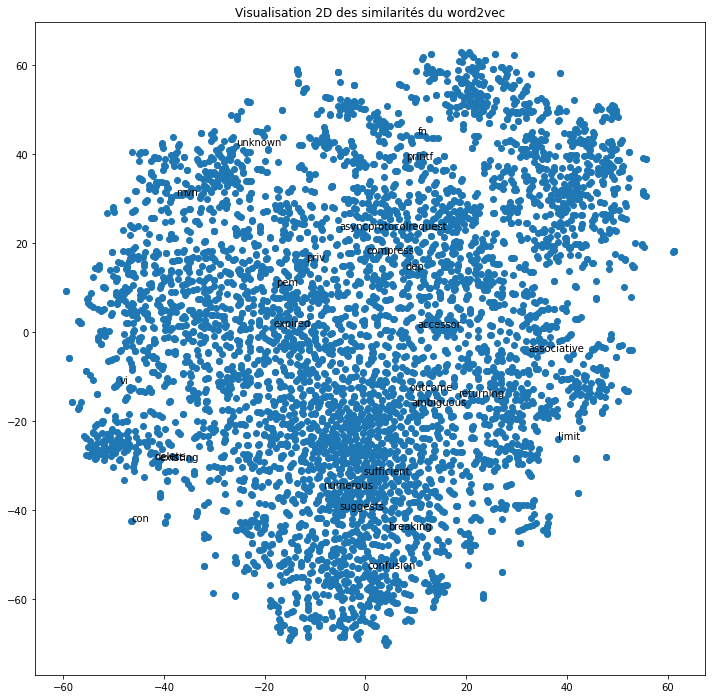

In [60]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model_w2v)

def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals, cmap='Spectral')
    plt.title('Visualisation 2D des similarités du word2vec')

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))
    
    plt.savefig('img/scatter_w2v.png', bbox_inches='tight')

    plt.show()

# plot_function(x_vals, y_vals, labels)

plot_with_matplotlib(x_vals, y_vals, labels);

<a id="3"></a>
# 3. Approche non supervisée
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Sommaire</a>

---

<a id="3.1"></a>
## 3.1 LDA

>L’allocation de Dirichlet latente (Latent Dirichlet Allocation) ou LDA est un modèle génératif probabiliste  
>permettant d’expliquer des ensembles d’observations, par le moyen de groupes non observés,  
>eux-mêmes définis par des similarités de données.

Nous séparerons tout d'abord notre jeu de donnée.  
Puis nous les vectoriserons.  
Ensuite nous choisirons les hyperparamètre de la LDA afin d'entrainer un modèle. 

Option :
* pyLDAvis

In [18]:
from sklearn.model_selection import train_test_split

X_lda_train, X_lda_test, y_lda_train, y_lda_test = train_test_split(
    df['Text'], df['Tags'], test_size=0.2,train_size=0.8, random_state=42)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Sampling dataset
vectorizer_tfidf = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                   strip_accents = None, encoding = 'utf-8', 
                                   preprocessor=None, 
                                   token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                   max_features=10000)

# TF-IDF matrices
X_tfidf_train = vectorizer_tfidf.fit_transform(X_lda_train)
X_tfidf_test = vectorizer_tfidf.transform(X_lda_test)

L(w) est la log-vraisemblance des documents non vus w ; plus la perplexité est faible, meilleur est le modèle.

Extracting term frequency features for LDA...


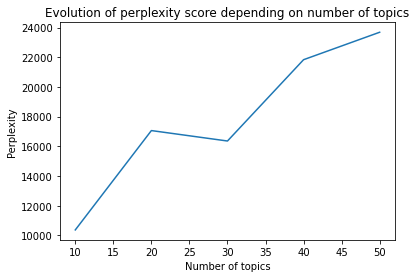

In [20]:
from sklearn.decomposition import LatentDirichletAllocation

def lda_perplexity(vectorizer, data_train, data_test):

    ''' Showing the perplexity score for several LDA models with different values
    for n_components parameter, and printing the top words for the best LDA model
    (the one with the lowest perplexity)
    Parameters:
    vectorizer: TF-IDF convertizer                                              
    data_train: data to fit the model with
    data_test: data to test
    '''

    best_perplexity = np.inf
    best_lda = 0
    perplexity_list = []
    n_topics_list = []
    print("Extracting term frequency features for LDA...")

    for n_topics in np.linspace(10, 50, 5, dtype='int'):
        lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state=0).fit(data_train)
        n_topics_list.append(n_topics)
        perplexity = lda_model.perplexity(data_test)
        perplexity_list.append(perplexity)

        # Perplexity is defined as exp(-1. * log-likelihood per word)
        # Perplexity: The smaller the better
        if perplexity <= best_perplexity:
            best_perplexity = perplexity
            best_lda = lda_model
                                
    plt.title("Evolution of perplexity score depending on number of topics")
    plt.xlabel("Number of topics")
    plt.ylabel("Perplexity")
    plt.plot(n_topics_list, perplexity_list)
    plt.savefig('img/complexity.png', bbox_inches='tight')

    plt.show()

lda_perplexity(vectorizer_tfidf, X_tfidf_train, X_tfidf_test)

Le score de perplexité le plus bas est pour 10 sujets, nous allons donc apprendre le modèle LDA avec 10 sujets.

La vectorisation sera faite grâce à un tfidf vectorizer de sklearn.

In [21]:
n_topics = 10

lda_model_tfidf = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0).fit(X_tfidf_train)

feature_names = vectorizer_tfidf.get_feature_names()
lda_components = lda_model_tfidf.components_ / lda_model_tfidf.components_.sum(axis=1)[:, np.newaxis] # normalization

Entrainons également un modèle qui se base sur un Countvectorizer.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_tf = CountVectorizer(max_features=10000)
X_tf_train = vectorizer_tf.fit_transform(X_lda_train)

n_topics = 10

lda_model_tf = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0).fit(X_tf_train)

In [23]:
def return_tag(text_test, vectorizer, model):

    text_tfidf = vectorizer.transform(text_test)
    text_projection = model.transform(text_tfidf)

    threshold = 0.005 # defined after tests
    list_scores = []
    list_words = []
    used = set()

    lda_components = model.components_ / model.components_.sum(axis=1)[:, np.newaxis] # normalization
    feature_names = vectorizer.get_feature_names()

    for topic in range(n_topics):
        topic_score = text_projection[0][topic]

        for (word_idx, word_score) in zip(lda_components[topic].argsort()[:-5:-1], sorted(lda_components[topic])[:-5:-1]):
            score = topic_score*word_score

            if score >= threshold:
                list_scores.append(score)
                list_words.append(feature_names[word_idx])
                used.add(feature_names[word_idx])

    results = [tag for (y,tag) in sorted(zip(list_scores,list_words), key=lambda pair: pair[0], reverse=True)]
    tags = " ".join(results[:5])

    return tags

In [24]:
# sample
text_test = [X_lda_test[0]]

return_tag(text_test, vectorizer_tfidf, lda_model_tfidf)
return_tag(text_test, vectorizer_tf, lda_model_tf)
y_lda_test[0]

'string array value list'

'string value return object table'

'php array string'

Pour l'évaluation du modèle nous allons prédire les tags et les comparer visuellement aux valeurs réelles.

In [25]:
y_pred_tf = X_lda_test.apply(lambda x: return_tag([x], vectorizer_tf, lda_model_tf))
y_pred_tfidf = X_lda_test.apply(lambda x: return_tag([x], vectorizer_tfidf, lda_model_tfidf))

In [26]:
df_results = pd.DataFrame({'y_true' : X_lda_test, 'y_pred_tf' : y_pred_tf, 'y_pred_tfidf' : y_pred_tfidf})
df_results.head(10)

,y_true,y_pred_tf,y_pred_tfidf
CreationDate,,,
2011-09-20 19:13:46,array string php best method converting php ar...,string value return object table,string array value list
2013-08-20 01:51:21,bootstrap collapse show state icon using core ...,div function text html,div git image cs color
2015-10-02 16:46:10,prevent autocomplete visual studio code using ...,file window use would system,file
2008-09-15 14:04:43,determine cpu memory inside process task deter...,use would one code file,file
2010-08-07 14:37:42,multiple downloads using wget using wget downl...,file line way like http,
2013-06-16 05:09:50,understanding garbage collection .net consider...,string value return object,file
2012-04-27 08:19:27,difference use getapplicationcontext someclass...,android java layout org string,file
2009-11-05 20:55:03,import existing git repository another git rep...,git file date branch repository,git branch commit repository
2011-10-07 11:02:47,jump method go back previous method making jum...,file line way like window,file


Nous constatons que l'approche non supervisée donne systématiquement des tags différents de ceux réels.  
Pour aller plus loin nous pourrions utiliser fastLDA.

<a id="3.2"></a>
## 3.2 NMF

Une autre type de modélisation de sujet automatique non supervisée est NMF (Negative Matrix Factorisation).


In [27]:
from sklearn.decomposition import NMF

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    analyzer=lambda x: x, # disable the analyser as we already have tokens
    stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df.Text_tok)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics,
random_state=1,
alpha=.1,
l1_ratio=.5,
init='nndsvd') # Nonnegative Double Singular Value Decomposition (NNDSVD) initialization (better for sparseness)

nmf.fit(tfidf)

NMF(alpha=0.1, init='nndsvd', l1_ratio=0.5, n_components=20, random_state=1)

In [28]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10

In [29]:
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
use would user error using code get like http application
Topic 1:
file directory folder path txt open filename name read want
Topic 2:
android layout id app activity view studio com parent width
Topic 3:
string character convert str split replace number way char hello
Topic 4:
git branch commit repository remote master push change github origin
Topic 5:
div px cs element text image width height html id
Topic 6:
table column sql mysql database row query data select id
Topic 7:
array element numpy arr var way javascript index php int
Topic 8:
class public method static int void test private foo name
Topic 9:
line command script bash text run window output vim echo
Topic 10:
list item element arraylist way index sort new would like
Topic 11:
function javascript return var jquery call script event alert php
Topic 12:
difference v use two one explain used ruby example understand
Topic 13:
date format time datetime day mm month current convert dd
Topic 14:
python py install package

<a id="4"></a>
# 4. Approche supervisée
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Sommaire</a>

---



<a id="4.1"></a>
## 4.1 Doc2vec

Doc2vec est un algorithme supervisé de plongement de mots.
Les algorithmes utilisés dans l'architecture de doc2vec sont “distributed memory” (dm) et “distributed bag of words” (dbow).

Pour ce plongement de mots il est nécessaire d'associer les tags au corpus.  
Nous séparerons tout d'abord notre jeu de données en train et test.

In [65]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df["Text_tok"], df['Tags_tok'], test_size=0.3, random_state=42)

In [31]:
# we need to put our data in a specific form for doc2vec
train_corpus = [models.doc2vec.TaggedDocument(doc, i) for doc, i in zip(x_train, y_train)]

In [32]:
test_corpus = x_test.to_list()

In [33]:
# instancing the model
model_d2v = models.doc2vec.Doc2Vec(vector_size=50,
min_count=2,
epochs=40)

In [34]:
model_d2v.build_vocab(train_corpus)

In [35]:
# sample
print(f"Word 'android' appeared {model_d2v.wv.get_vecattr('android', 'count')} times in the training corpus.")


Word 'android' appeared 8627 times in the training corpus.


In [36]:
model_d2v.train(train_corpus, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)

Les problèmes de **classification multi-label** doivent être évalués à l'aide de mesures de performance différentes des problèmes de classification mono-étiquette.  
Deux des mesures de performance les plus courantes sont "hamming loss" et la "Jaccard similarity". Nous utiliserons ici cette dernière.

**Jaccard similarity** : la taille de l'intersection des étiquettes prédites et des étiquettes vraies divisée par la taille de l'union des étiquettes prédites et vraies.  
Il va de 0 à 1, et 1 est le score parfait.

In [69]:
import warnings

# I expect to see RuntimeWarnings in this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

    scores = []
    y_pred = []
    y_true = []

    for i in range(0, len(y_test)-1):
        inferred_vector = model_d2v.infer_vector(test_corpus[i])
        sims = model_d2v.dv.most_similar([inferred_vector], topn=len(set(y_test[i])))
        # [w[0] for w in sims]
        # y_test[i]

        y_pred.append(sorted(set([w[0] for w in sims])))
        y_true.append(sorted(set(y_test[i])))
        
        scores.append(metrics.jaccard_score(y_true[i], y_pred[i], average="weighted"))

In [71]:
from statistics import mean

mean([s for s in scores if str(s) != 'nan'])*100

11.340750577432738

In [73]:
df_d2v_results = pd.DataFrame({'y_true' : y_true, 'y_pred' : y_pred})
df_d2v_results.head(10)

,y_true,y_pred
0,"[array, php, string]","[gjslint, mat, nspointerarray]"
1,"[bootstrap, cs, jquery, twitter]","[cpp, guideline, jsfiddle, tooltip]"
2,"[code, setting, studio, visual, vscode]","[collapse, fieldset, hiveql, ide, product]"
3,"[c, cpu, memory]","[finish, preemption, sourcekit]"
4,"[download, wget]","[cgi, crontab]"
5,"[.net, c#, collection, garbage]","[delivery, encapsulation, synchronized, unmana..."
6,"[android, context, intent, toast]","[dllregistration, inject, login, spring]"
7,"[git, merge]","[git, letter]"
8,"[editor, studio, visual]","[ivr, keyboard, wireframe]"
9,"[database, postgresql, timestamp]","[bank, mysql, postgresql]"


<a id="4.2"></a>
## 4.2 SGD, Logistic regression, LinearSVC

Nous allons maintenant entrainer les modèles SGD, Logistic regression, LinearSVC avec le classifieur One versus Rest.

Pour cela nous commencerons par encoder nos tags avec un multilabel binarizer.  
Puis nous séparerons nos données en entrainement/test. Ensuit un vectorizer de type tf-idf nous permettra de les transformer avant de leur appliquer les algorithmes ci dessus.

Enfin nous les évaluerons avec un Jaccard score.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.multiclass import OneVsRestClassifier

In [40]:
df['Tags_tok'].head()

CreationDate
2010-09-27 06:56:36                 [c#, .net, wpf, mvvm, modal, dialog]
2008-08-11 08:55:13           [c, binary, bit, manipulation, bit, shift]
2008-08-11 10:27:22    [database, database, design, language, naming,...
2008-08-11 11:57:17                                        [sql, server]
2008-08-10 18:41:02                          [theory, machine, complete]
Name: Tags_tok, dtype: object

In [41]:
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(df['Tags_tok'])
y

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [42]:
ydf = pd.DataFrame(y, columns=multilabel.classes_)
ydf.head()

,.net,4net,aapt,aar,abort,absolute,abstract,abstraction,access,accessor,...,year,yield,youtube,yum,zend,zero,zip,zoom,zsh,zurb
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
vec_tfidf = TfidfVectorizer(
    analyzer='word',
    max_features=10000)

In [76]:
X = vec_tfidf.fit_transform(df['Text'].values)
X.shape, y.shape

((28077, 5261), (28077, 2834))

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [46]:
sgd = SGDClassifier()
lr = LogisticRegression(solver='lbfgs')
svc = LinearSVC()

In [47]:
def j_score(y_true, y_pred):
  jaccard = np.minimum(y_true, y_pred).sum(axis = 1)/np.maximum(y_true, y_pred).sum(axis = 1)
  return jaccard.mean()*100


def print_score(y_pred, y_test, clf):
  print("Clf: ", clf.__class__.__name__)
  print('Jaccard score: {}'.format(j_score(y_test, y_pred)))
  print('----')

def get_best_tags(clf, X, lb, n_tags=3):
  decfun = clf.decision_function(X)
  best_tags = np.argsort(decfun)[:, :-(n_tags+1): -1]
  return lb.classes_[best_tags]

In [48]:
import warnings

# I expect to see RuntimeWarnings in this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)

    for classifier in [sgd, lr, svc]:
      clf = OneVsRestClassifier(classifier)
      clf.fit(X_train, y_train) 
      # y_pred = clf.predict(X_test)
      best_tags = get_best_tags(clf, X_test, multilabel)
      y_pred = multilabel.transform(best_tags)
      print_score(y_pred, y_test, classifier)

OneVsRestClassifier(estimator=SGDClassifier())

Clf:  SGDClassifier
Jaccard score: 22.054261582039363
----


OneVsRestClassifier(estimator=LogisticRegression())

Clf:  LogisticRegression
Jaccard score: 16.706728456728456
----


OneVsRestClassifier(estimator=LinearSVC())

Clf:  LinearSVC
Jaccard score: 29.64372253261142
----


Nous choisirons un modèle LinearSVC pour estimer les tags d'une nouvelle question.  
Tentons d'améliorer le score de Jaccard.

In [79]:
svc = LinearSVC(C=1.5, penalty='l1', dual=False)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)

    for classifier in [svc]:
      clf_svc = OneVsRestClassifier(classifier)
      clf_svc.fit(X_train, y_train) 
      best_tags = get_best_tags(clf_svc, X_test, multilabel)
      y_pred = multilabel.transform(best_tags)
      print_score(y_pred, y_test, classifier)

OneVsRestClassifier(estimator=LinearSVC(C=1.5, dual=False, penalty='l1'))

Clf:  LinearSVC
Jaccard score: 32.506987354209585
----


In [92]:
y_pred_tags = [' '.join(best_tags[i]) for i in range(len(best_tags))]

In [93]:
df_SVC_results = pd.DataFrame({'y_true' : multilabel.inverse_transform(y_test), 'y_pred' : y_pred_tags})
df_SVC_results.head(10)

,y_true,y_pred
0,"(array, php, string)",php array saaj
1,"(bootstrap, cs, jquery, twitter)",bootstrap twitter jquery
2,"(code, setting, studio, visual, vscode)",studio visual groupwise
3,"(c, cpu, memory)",memory hdf derived
4,"(download, wget)",wget linux reportingservices
5,"(.net, c#, collection, garbage)",c# collection garbage
6,"(android, context, intent, toast)",android toast deploy
7,"(git, merge)",git pkgbuild mf
8,"(editor, studio, visual)",remove threadcontext mf
9,"(database, postgresql, timestamp)",postgresql sql training


Ce modèle ayant la meilleure performance ce sera celui ci que nous utiliserons pour la prédiction de nos tags via API.

Nous pourrions également tenter de jouer sur les paramètres de tfidf, par exemple ngram_range=(1, 2).

In [50]:
# sample
x = [ 'how to write ml code in python and java i have data but do not know how to do it']
xt = vec_tfidf.transform(x)
get_best_tags(clf_svc, xt, multilabel)

array([['file', 'python', 'renaming']], dtype=object)

<a id="5"></a>
# 5. Installation du modèle sur API
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Sommaire</a>

---

Pour le déploiement du modèle sur une API nous devrons le sauvegarder en fichier pour que le serveur puisse s'en servir.  
De plus le process de prédiction devra être mis en forme pour s'adapter à Flask.

<a id="5.1"></a>
## 5.1 Dump

In [51]:
joblib.dump(clf_svc, "clf_svc.pkl", compress=3)
joblib.dump(multilabel, "multilabel.pkl")
joblib.dump(vec_tfidf, "vec_tfidf.pkl") # joblib doesn't want to put this one in models repertory

['clf_svc.pkl']

['multilabel.pkl']

['vec_tfidf.pkl']

<a id="5.2"></a>
## 5.2 Mise en forme process

In [52]:
import joblib

def import_model():
    model = joblib.load("clf_svc.pkl")
    sw = joblib.load("sw.pkl")
    lb = joblib.load("multilabel.pkl")
    vec = joblib.load("vec_tfidf.pkl")
    return (model, sw, lb, vec)

In [53]:

model, sw, lb, vec = import_model()

In [54]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
import contractions

def cleaner(text):
    """Remove Html tags, extra spaces, ; put in lowercase"""

    text = BeautifulSoup(text, 'html.parser')
    text = text.get_text(strip=True)
    text = contractions.fix(text) # remove contractions 's => is...
    text = re.sub(r"\n", " ", text) # match all literal Line Feed (New line) pattern then replace them by a single whitespace
    text = re.sub(r'\s+', ' ', text) # match all one or more whitespace then replace them by a single whitespace
    text = text.lower()

    return text

def tokeniser(text):
    return nltk.RegexpTokenizer(r'[a-zA-Z]{2,}|c#?|.net').tokenize(text)

def remove_stopwords(list_of_words, sw):
    """remove common words in english by using nltk.corpus's list"""

    list_of_words = [w for w in list_of_words if not w in sw]
    return list_of_words


def lem_text(list_of_words):
    """Lemmatization of the text"""

    lemmatizer = nltk.WordNetLemmatizer()
    list_of_words = [lemmatizer.lemmatize(w) for w in list_of_words] # Lemmatize each words
    return list_of_words

In [55]:
def text_treatment(input_txt, sw):
   txt = cleaner(input_txt)
   txt = tokeniser(txt)
   txt = remove_stopwords(txt, sw)
   txt = lem_text(txt)
   # vectorizer needs a  list of strings
   # it then tokenise it
   txt = [' '.join(txt)] 
   return txt

def vectorize(x, vec):
   return vec.transform(x)

def get_best_tags(clf, X, lb, n_tags=3):
    decfun = clf.decision_function(X)
    best_tags = np.argsort(decfun)[:, :-(n_tags+1): -1]
    return lb.classes_[best_tags]

In [56]:
def treat_text_get_tags(x, model, lb, vec, sw):
    x_clean = text_treatment(str(x), sw)
    x_vec = vectorize(x_clean, vec)
    return get_best_tags(model, x_vec, lb)

treat_text_get_tags(x, model, lb, vec, sw)

array([['python', 'java', 'string']], dtype=object)

<a id="6"></a>
# 6. Interpretation et conclusion
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Sommaire</a>

---

Les résultats obtenus semblent pertinents dans leur contexte.  
Néanmoins ils sont souvent différents de ceux prédit par Stackoverflow.

Un grand nombre d'hyperparamètres peuvent permettrent d'améliorer le modèle sélectionné pour s'approcher d'avantage des étiquettes du site.

Notre approche ne permet cependant pas d'ajouter de nouveaux tags au fur et à mesure des nouvelles questions.  
Il sera pour cela nécessaire de réentrainer un modèle.

De plus il serait pertinent d'utiliser des dictionnaires spécifiques au domaine pour gagner en précision.  
Cela permettrait par exemple de traiter correctement des mots comme "R, c, pandas, etc."